# 🔍 Diffusion-Based Deepfake Detection Training

Train a LaDeDa ResNet50 model to classify real vs diffusion-generated fake images.

## Dataset Structure
```
newfinetune2/
├── train/
│   ├── real/*.jpg
│   └── fake/*.jpg
├── val/
│   ├── real/*.jpg
│   └── fake/*.jpg
└── test/
    ├── real/*.jpg
    └── fake/*.jpg
```

## 1. Imports & Setup

In [1]:
import os
import sys
import json
import random
import io
import time
from pathlib import Path
from dataclasses import dataclass, field
from typing import Tuple, List, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image, ImageOps, ImageFilter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"🖥️  GPU: {torch.cuda.get_device_name(0)}")

✅ Using device: cuda
🖥️  GPU: Tesla T4


## 2. Configuration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/newfinetune2.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/newfinetune2/test/fake/sample_6718.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6725.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6727.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6731.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6732.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6734.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6738.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6740.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6747.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6748.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6751.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6753.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6756.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6759.jpg  
  inflating: /content/newfinetune2/test/fake/sample_6761.jpg  
  in

In [4]:
@dataclass
class TrainingConfig:
    """Training configuration."""
    # Paths - UPDATE THIS TO YOUR DATASET PATH
    data_path: str = "/content/newfinetune2"
    output_dir: str = "/content/outputs"

    # Training parameters
    epochs: int = 15
    batch_size: int = 16
    lr: float = 3e-5
    weight_decay: float = 1e-4

    # Model
    freeze_layers: List[str] = field(default_factory=lambda: ["conv1", "layer1"])

    # Other
    num_workers: int = 2
    seed: int = 42


@dataclass
class AugmentConfig:
    """Augmentation configuration."""
    jpeg_qualities: List[int] = field(default_factory=lambda: [50, 75, 95])
    resize_scales: List[float] = field(default_factory=lambda: [0.75, 1.25])
    blur_sigmas: List[float] = field(default_factory=lambda: [0.5, 1.0])
    noise_sigmas: List[float] = field(default_factory=lambda: [3.0, 6.0])
    brightness_range: Tuple[float, float] = (0.9, 1.1)
    contrast_range: Tuple[float, float] = (0.9, 1.1)

    p_jpeg: float = 0.5
    p_resize: float = 0.3
    p_blur: float = 0.3
    p_noise: float = 0.3
    p_color: float = 0.3
    p_flip: float = 0.5


# Constants
TARGET_SIZE = (256, 256)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Initialize configs
config = TrainingConfig()
augment_config = AugmentConfig()

print(f"📁 Data path: {config.data_path}")
print(f"📁 Output dir: {config.output_dir}")
print(f"🔢 Epochs: {config.epochs}, Batch size: {config.batch_size}, LR: {config.lr}")

📁 Data path: /content/newfinetune2
📁 Output dir: /content/outputs
🔢 Epochs: 15, Batch size: 16, LR: 3e-05


## 3. Utility Functions

In [5]:
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

set_seed(config.seed)
print(f"🎲 Seed set to {config.seed}")

🎲 Seed set to 42


## 4. Data Loading

In [6]:
@dataclass
class ImageMetadata:
    """Metadata for a single image."""
    path: Path
    label: int  # 0 = real, 1 = fake
    image_id: str

    @classmethod
    def from_path(cls, path: Path, label: int):
        return cls(path=path, label=label, image_id=path.stem)


def load_split(data_root: Path, split: str) -> List[ImageMetadata]:
    """Load images from a split directory."""
    images = []
    split_dir = data_root / split

    for label, class_name in [(0, "real"), (1, "fake")]:
        class_dir = split_dir / class_name
        if not class_dir.exists():
            continue

        for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
            for path in class_dir.glob(ext):
                images.append(ImageMetadata.from_path(path, label))

    return images

In [7]:
# Load data
print("📂 Loading dataset...")
data_root = Path(config.data_path)

train_images = load_split(data_root, "train")
val_images = load_split(data_root, "val")
test_images = load_split(data_root, "test")

print(f"  ✅ Train: {len(train_images)} images")
print(f"  ✅ Val: {len(val_images)} images")
print(f"  ✅ Test: {len(test_images)} images")

📂 Loading dataset...
  ✅ Train: 4000 images
  ✅ Val: 500 images
  ✅ Test: 500 images


## 5. Augmentation Pipeline

In [8]:
def jpeg_compress(image: Image.Image, quality: int) -> Image.Image:
    """Apply JPEG compression."""
    if image.mode != "RGB":
        image = image.convert("RGB")
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG", quality=quality, subsampling=0)
    buffer.seek(0)
    out = Image.open(buffer)
    out.load()
    buffer.close()
    return out


def resize_chain(image: Image.Image, scale: float) -> Image.Image:
    """Downscale then upscale to simulate re-upload artifacts."""
    w, h = image.size
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))
    image = image.resize((new_w, new_h), Image.Resampling.BILINEAR)
    image = image.resize((w, h), Image.Resampling.BILINEAR)
    return image


def gaussian_blur(image: Image.Image, sigma: float) -> Image.Image:
    """Apply Gaussian blur."""
    return image.filter(ImageFilter.GaussianBlur(radius=sigma))


def add_sensor_noise(image: Image.Image, sigma: float) -> Image.Image:
    """Add Gaussian sensor noise."""
    arr = np.asarray(image, dtype=np.float32)
    noise = np.random.normal(0, sigma, arr.shape)
    noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)


def adjust_brightness_contrast(image: Image.Image, brightness: float, contrast: float) -> Image.Image:
    """Adjust brightness and contrast."""
    arr = np.asarray(image, dtype=np.float32)
    arr = arr * brightness
    mean = arr.mean()
    arr = (arr - mean) * contrast + mean
    return Image.fromarray(np.clip(arr, 0, 255).astype(np.uint8))


class AugmentationPipeline:
    """Augmentation pipeline for training."""

    def __init__(self, config: AugmentConfig = None):
        self.config = config or AugmentConfig()

    def __call__(self, image: Image.Image) -> Image.Image:
        if image.mode != "RGB":
            image = image.convert("RGB")

        c = self.config

        if random.random() < c.p_flip:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        if random.random() < c.p_jpeg:
            image = jpeg_compress(image, random.choice(c.jpeg_qualities))

        if random.random() < c.p_resize:
            image = resize_chain(image, random.choice(c.resize_scales))

        if random.random() < c.p_blur:
            image = gaussian_blur(image, random.choice(c.blur_sigmas))

        if random.random() < c.p_noise:
            image = add_sensor_noise(image, random.choice(c.noise_sigmas))

        if random.random() < c.p_color:
            image = adjust_brightness_contrast(
                image,
                random.uniform(*c.brightness_range),
                random.uniform(*c.contrast_range),
            )

        return image

print("✅ Augmentation pipeline defined")

✅ Augmentation pipeline defined


## 6. Dataset Class

In [9]:
class DeepfakeDataset(Dataset):
    """Dataset for deepfake detection."""

    def __init__(
        self,
        images: List[ImageMetadata],
        augment: bool = True,
        augment_config: AugmentConfig = None,
    ):
        self.images = tuple(images)
        self.augment = augment
        self.aug_pipeline = AugmentationPipeline(augment_config) if augment else None

        n_real = sum(1 for img in self.images if img.label == 0)
        n_fake = sum(1 for img in self.images if img.label == 1)
        aug_str = "✅ augmented" if augment else "❌ no augmentation"

        print(f"  📊 Dataset: {len(self.images)} images (Real: {n_real}, Fake: {n_fake}) [{aug_str}]")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        meta = self.images[idx]

        # Load image
        with Image.open(meta.path) as img:
            img = ImageOps.exif_transpose(img)
            img = img.convert("RGB")

        # Apply augmentation
        if self.augment and self.aug_pipeline:
            img = self.aug_pipeline(img)

        # Resize to target size
        img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)

        # Convert to tensor with ImageNet normalization
        arr = np.asarray(img, dtype=np.float32) / 255.0
        arr = (arr - IMAGENET_MEAN) / IMAGENET_STD
        tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()

        return {
            "image": tensor,
            "label": torch.tensor(meta.label, dtype=torch.long),
            "image_id": meta.image_id,
        }


def collate_fn(batch):
    """Custom collate function."""
    return {
        "image": torch.stack([b["image"] for b in batch], dim=0),
        "label": torch.stack([b["label"] for b in batch], dim=0),
        "image_id": [b["image_id"] for b in batch],
    }

print("✅ Dataset class defined")

✅ Dataset class defined


In [20]:
# Create datasets
print("📦 Creating datasets...")
train_dataset = DeepfakeDataset(train_images, augment=True, augment_config=augment_config)
val_dataset = DeepfakeDataset(val_images, augment=True)
test_dataset = DeepfakeDataset(test_images, augment=False)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    collate_fn=collate_fn,
)

print(f"\n✅ DataLoaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

📦 Creating datasets...
  📊 Dataset: 4000 images (Real: 2000, Fake: 2000) [✅ augmented]
  📊 Dataset: 500 images (Real: 250, Fake: 250) [✅ augmented]
  📊 Dataset: 500 images (Real: 250, Fake: 250) [❌ no augmentation]

✅ DataLoaders: 250 train, 32 val, 32 test batches


## 7. Model Architecture: LaDeDa ResNet50

In [21]:
class AttentionPooling(nn.Module):
    """Attention-based pooling over patch logits."""

    def __init__(self, in_channels=2048, hidden_dim=512):
        super().__init__()
        self.attention_fc = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, 1, kernel_size=1),
        )

    def forward(self, features, patch_logits):
        attn_scores = self.attention_fc(features)

        B, _, H, W = attn_scores.shape
        attn_flat = attn_scores.view(B, -1)
        attn_flat = attn_flat - attn_flat.max(dim=1, keepdim=True)[0]
        attn = F.softmax(attn_flat, dim=1).view(B, 1, H, W)

        pooled = (patch_logits * attn).sum(dim=(2, 3))
        return pooled, attn


class LaDeDaResNet50(nn.Module):
    """LaDeDa-style ResNet50 for deepfake detection."""

    def __init__(self, pretrained=True, freeze_layers=None):
        super().__init__()

        base = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        # Modified conv1: 3x3 instead of 7x7
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        if pretrained:
            with torch.no_grad():
                self.conv1.weight.copy_(base.conv1.weight[:, :, 2:5, 2:5])

        self.bn1 = base.bn1
        self.relu = base.relu

        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4

        self.patch_classifier = nn.Conv2d(2048, 1, kernel_size=1)
        self.attention_pool = AttentionPooling(2048)

        self.freeze_layers = freeze_layers or []
        self._freeze()

    def _freeze(self):
        freeze_map = {
            "conv1": [self.conv1, self.bn1],
            "layer1": [self.layer1],
            "layer2": [self.layer2],
            "layer3": [self.layer3],
            "layer4": [self.layer4],
        }
        for name in self.freeze_layers:
            if name in freeze_map:
                for module in freeze_map[name]:
                    for p in module.parameters():
                        p.requires_grad = False

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        patch_logits = self.patch_classifier(x)
        pooled_logits, attn = self.attention_pool(x, patch_logits)
        pooled_logits = pooled_logits.view(-1)

        return pooled_logits, patch_logits, attn

print("✅ Model architecture defined")

✅ Model architecture defined


In [22]:
# Create model
print("🔧 Initializing model...")
model = LaDeDaResNet50(pretrained=True, freeze_layers=config.freeze_layers)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  📊 Total params: {total_params:,}")
print(f"  📊 Trainable: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

🔧 Initializing model...
  📊 Total params: 24,552,002
  📊 Trainable: 24,334,338 (99.1%)


## 8. Metrics & Training Functions

In [23]:
def compute_metrics(preds, labels, probs=None) -> Dict:
    """Compute classification metrics."""
    preds = np.asarray(preds).astype(int)
    labels = np.asarray(labels).astype(int)

    acc = (preds == labels).mean()
    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()

    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    metrics = {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
    }

    if probs is not None:
        try:
            from sklearn.metrics import roc_auc_score
            metrics["auc"] = float(roc_auc_score(labels, probs))
        except Exception:
            pass

    return metrics


def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    all_probs, all_labels = [], []

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch in pbar:
        images = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(device.type == "cuda")):
            pooled, _, _ = model(images)
            pooled = pooled.view(-1)
            loss = criterion(pooled, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labels.size(0)
        probs = torch.sigmoid(pooled).detach().view(-1).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    all_probs = np.asarray(all_probs)
    all_labels = np.asarray(all_labels)

    metrics = compute_metrics((all_probs > 0.5).astype(int), all_labels, all_probs)
    metrics["loss"] = total_loss / len(all_labels)
    return metrics


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            images = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True).float()

            pooled, _, _ = model(images)
            pooled = pooled.view(-1)
            loss = criterion(pooled, labels)

            total_loss += loss.item() * labels.size(0)
            probs = torch.sigmoid(pooled).view(-1).cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    all_probs = np.asarray(all_probs)
    all_labels = np.asarray(all_labels)

    metrics = compute_metrics((all_probs > 0.5).astype(int), all_labels, all_probs)
    metrics["loss"] = total_loss / len(all_labels)
    return metrics


def evaluate(model, dataloader, device):
    """Evaluate the model."""
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            images = batch["image"].to(device)
            labels = batch["label"].cpu().numpy().astype(int)

            pooled, _, _ = model(images)
            probs = torch.sigmoid(pooled).view(-1).cpu().numpy()

            all_probs.extend(probs.tolist())
            all_labels.extend(labels.tolist())

    all_probs = np.asarray(all_probs)
    all_labels = np.asarray(all_labels)

    return compute_metrics((all_probs > 0.5).astype(int), all_labels, all_probs)

print("✅ Training functions defined")

✅ Training functions defined


## 9. Setup Optimizer, Scheduler & Loss

In [24]:
# Setup directories
os.makedirs(config.output_dir, exist_ok=True)
checkpoint_dir = os.path.join(config.output_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Loss, optimizer, scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.lr,
    weight_decay=config.weight_decay
)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2, eta_min=1e-6
)
scaler = GradScaler()

print(f"✅ Loss: BCEWithLogitsLoss")
print(f"✅ Optimizer: AdamW (lr={config.lr}, wd={config.weight_decay})")
print(f"✅ Scheduler: CosineAnnealingWarmRestarts")
print(f"✅ Checkpoint dir: {checkpoint_dir}")

✅ Loss: BCEWithLogitsLoss
✅ Optimizer: AdamW (lr=3e-05, wd=0.0001)
✅ Scheduler: CosineAnnealingWarmRestarts
✅ Checkpoint dir: /content/outputs/checkpoints


/tmp/ipython-input-3924948769.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 10. Training Loop 🚀

Training with checkpoints saved after each epoch. Best model is saved based on validation F1 score.

In [25]:
# Step 1: Load checkpoint
start_epoch, history = resume_from_checkpoint(os.path.join(checkpoint_dir, "checkpoint_epoch_10.pth"))

# Step 2: Reinitialize GradScaler (IMPORTANT - fixes the error!)
scaler = GradScaler()

# Step 3: Now run your training loop starting from epoch 9

NameError: name 'resume_from_checkpoint' is not defined

In [26]:
# Training loop
print("\n" + "=" * 60)
print("🚀 TRAINING")
print("=" * 60)

best_val_f1 = 0
history = {"train": [], "val": []}
start_time = time.time()

for epoch in range(config.epochs):
    print(f"\n📅 Epoch {epoch + 1}/{config.epochs}")
    print("-" * 40)

    # Train
    train_metrics = train_epoch(model, train_loader, criterion, optimizer, scaler, device)

    # Validate
    val_metrics = validate(model, val_loader, criterion, device)

    scheduler.step()

    history["train"].append(train_metrics)
    history["val"].append(val_metrics)

    print(f"Train | Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f} | F1: {train_metrics['f1']:.4f}")
    print(f"Val   | Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f} | F1: {val_metrics['f1']:.4f}")

    # Save checkpoint every epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "history": history,
    }, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

    # Save best model
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        best_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_metrics": val_metrics,
        }, best_path)
        print(f"⭐ New best model! (Val F1: {best_val_f1:.4f})")

total_time = time.time() - start_time
print(f"\n✅ Training complete in {total_time/60:.1f} minutes")
print(f"🏆 Best Val F1: {best_val_f1:.4f}")


🚀 TRAINING

📅 Epoch 1/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.6488 | Acc: 0.6650 | F1: 0.7042
Val   | Loss: 0.5534 | Acc: 0.7440 | F1: 0.7630
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_1.pth
⭐ New best model! (Val F1: 0.7630)

📅 Epoch 2/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.5221 | Acc: 0.7652 | F1: 0.7635
Val   | Loss: 0.5026 | Acc: 0.7520 | F1: 0.7257
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_2.pth

📅 Epoch 3/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.4822 | Acc: 0.7863 | F1: 0.7822
Val   | Loss: 0.4769 | Acc: 0.7800 | F1: 0.7708
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_3.pth
⭐ New best model! (Val F1: 0.7708)

📅 Epoch 4/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.4355 | Acc: 0.8110 | F1: 0.8116
Val   | Loss: 0.4519 | Acc: 0.7960 | F1: 0.8000
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_4.pth
⭐ New best model! (Val F1: 0.8000)

📅 Epoch 5/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.4259 | Acc: 0.8145 | F1: 0.8142
Val   | Loss: 0.4364 | Acc: 0.7940 | F1: 0.7944
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_5.pth

📅 Epoch 6/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.4310 | Acc: 0.8117 | F1: 0.8096
Val   | Loss: 0.4414 | Acc: 0.8200 | F1: 0.8235
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_6.pth
⭐ New best model! (Val F1: 0.8235)

📅 Epoch 7/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.4127 | Acc: 0.8307 | F1: 0.8281
Val   | Loss: 0.4285 | Acc: 0.8100 | F1: 0.8008
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_7.pth

📅 Epoch 8/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.3827 | Acc: 0.8343 | F1: 0.8336
Val   | Loss: 0.4763 | Acc: 0.8140 | F1: 0.8255
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_8.pth
⭐ New best model! (Val F1: 0.8255)

📅 Epoch 9/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.3485 | Acc: 0.8575 | F1: 0.8569
Val   | Loss: 0.4323 | Acc: 0.8240 | F1: 0.8204
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_9.pth

📅 Epoch 10/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.3226 | Acc: 0.8670 | F1: 0.8655
Val   | Loss: 0.4657 | Acc: 0.8260 | F1: 0.8168
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_10.pth

📅 Epoch 11/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.2863 | Acc: 0.8830 | F1: 0.8816
Val   | Loss: 0.4900 | Acc: 0.8060 | F1: 0.8094
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_11.pth

📅 Epoch 12/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.2760 | Acc: 0.8965 | F1: 0.8962
Val   | Loss: 0.4413 | Acc: 0.8340 | F1: 0.8310
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_12.pth
⭐ New best model! (Val F1: 0.8310)

📅 Epoch 13/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.2583 | Acc: 0.9038 | F1: 0.9037
Val   | Loss: 0.4580 | Acc: 0.8360 | F1: 0.8285
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_13.pth

📅 Epoch 14/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.2365 | Acc: 0.9130 | F1: 0.9122
Val   | Loss: 0.5316 | Acc: 0.8360 | F1: 0.8367
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_14.pth
⭐ New best model! (Val F1: 0.8367)

📅 Epoch 15/15
----------------------------------------


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-2417701914.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train | Loss: 0.2442 | Acc: 0.9083 | F1: 0.9070
Val   | Loss: 0.4691 | Acc: 0.8440 | F1: 0.8458
💾 Checkpoint saved: /content/outputs/checkpoints/checkpoint_epoch_15.pth
⭐ New best model! (Val F1: 0.8458)

✅ Training complete in 88.3 minutes
🏆 Best Val F1: 0.8458


## 11. Training Visualization

📈 Plot saved: /content/outputs/training_history.png


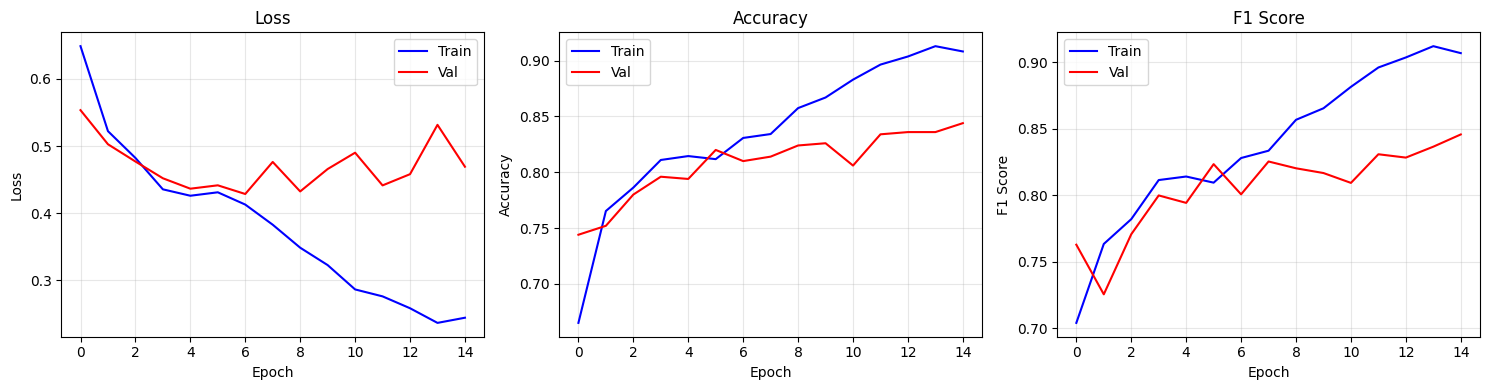

In [27]:
def plot_history(history: Dict, output_path: str = None):
    """Plot training history."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot([m['loss'] for m in history['train']], 'b-', label='Train')
    axes[0].plot([m['loss'] for m in history['val']], 'r-', label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot([m['accuracy'] for m in history['train']], 'b-', label='Train')
    axes[1].plot([m['accuracy'] for m in history['val']], 'r-', label='Val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1
    axes[2].plot([m['f1'] for m in history['train']], 'b-', label='Train')
    axes[2].plot([m['f1'] for m in history['val']], 'r-', label='Val')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"📈 Plot saved: {output_path}")
    plt.show()

# Plot training history
plot_history(history, os.path.join(config.output_dir, "training_history.png"))

## 12. Final Evaluation on Test Set

In [28]:
# Load best model and evaluate on test set
print("\n" + "=" * 60)
print("📊 FINAL EVALUATION")
print("=" * 60)

best_path = os.path.join(checkpoint_dir, "best_model.pth")
checkpoint = torch.load(best_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Loaded best model from epoch {checkpoint['epoch'] + 1}")

test_metrics = evaluate(model, test_loader, device)
print(f"\n🧪 Test Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1:        {test_metrics['f1']:.4f}")
if "auc" in test_metrics:
    print(f"  AUC:       {test_metrics['auc']:.4f}")


📊 FINAL EVALUATION
✅ Loaded best model from epoch 15


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]


🧪 Test Results:
  Accuracy:  0.8440
  Precision: 0.8359
  Recall:    0.8560
  F1:        0.8458
  AUC:       0.9327


## 13. Save Results

In [29]:
# Save final results
results = {
    "config": {
        "epochs": config.epochs,
        "batch_size": config.batch_size,
        "lr": config.lr,
        "data_path": config.data_path,
    },
    "best_val_f1": best_val_f1,
    "test_metrics": test_metrics,
    "training_time_minutes": total_time / 60,
    "history": history,
}

results_path = os.path.join(config.output_dir, "results.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {results_path}")
print(f"✅ Best model saved to: {best_path}")
print(f"✅ All checkpoints in: {checkpoint_dir}")


✅ Results saved to: /content/outputs/results.json
✅ Best model saved to: /content/outputs/checkpoints/best_model.pth
✅ All checkpoints in: /content/outputs/checkpoints


## 14. Resume Training (Optional)

Use this cell to resume training from a checkpoint.

In [ ]:
def resume_from_checkpoint(checkpoint_path: str):
    """Resume training from a checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    history = checkpoint.get("history", {"train": [], "val": []})
    print(f"✅ Resumed from epoch {start_epoch}")
    return start_epoch, history

# Example usage:
start_epoch, history = resume_from_checkpoint(os.path.join(checkpoint_dir, "checkpoint_epoch_8.pth"))
print("💡 To resume training, uncomment and run the line above with your checkpoint path.")

FileNotFoundError: [Errno 2] No such file or directory: './outputs/checkpoints/checkpoint_epoch_8.pth'

In [ ]:
!rm -rf outputs/checkpoints/